In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

from pywsi.normalization import MacenkoNormalization
from pywsi.normalization import ReinhardNormalization

from pywsi.io import WSIReader
from pywsi.io.operations import read_as_rgb
import numpy.linalg as LA
from skimage.filters import try_all_threshold

from sklearn.decomposition import NMF
from sklearn.decomposition import nmf
from sklearn.linear_model import Lasso

from sklearn.utils.testing import assert_array_almost_equal
from sklearn.utils.testing import assert_almost_equal
from numpy import linalg as LA
from skimage.color import rgb2gray
import spams

from skimage.feature import canny


def fractal_dimension(Z, threshold=0.9):

    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]


Populating the interactive namespace from numpy and matplotlib


/Z/personal-folders/interns/saket/github/pywsi/pywsi/io/operations.py:14: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/saket/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/saket/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/saket/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/saket/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/saket/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.

In [23]:
normal = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/normal/normal_003.tif'
tumor = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/tumor/tumor_054.tif'

tumor_wsi = WSIReader(tumor, 40)
normal_wsi = WSIReader(normal, 40)

In [24]:
x0 = int(59792/2)#30000
y0 = int(233184/2)

tumor_rgb = tumor_wsi.get_patch_by_level(x0, y0, level=0, patch_size=1000)



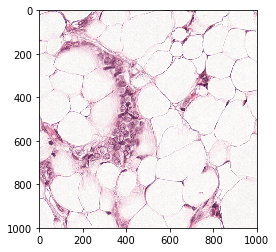

In [25]:
plt.imshow(tumor_rgb)


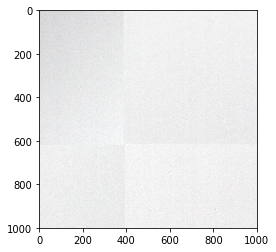

In [36]:
x0 = int(977)
y0 = int(2114)

normal_rgb = normal_wsi.get_patch_by_level(x0, y0, level=0, patch_size=1000)

plt.imshow(normal_rgb)

In [ ]:
plt.imshow(normal_wsi.get_patch_by_level(0, 0, level=0))#, patch_size=1000))

In [27]:
normal_wsi.level_dimensions[0]

(97792, 221184)

# Macenko normalization

In [7]:
macenko_fit = MacenkoNormalization()
macenko_fit.fit(np.asarray(tumor_rgb).astype(np.uint8))
normalized_rgb = macenko_fit.transform(np.asarray(normal_rgb).astype(np.uint8))

In [8]:
macenko_fit.target_stain_matrix.shape

(2, 3)

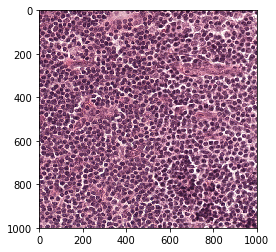

In [9]:
plt.imshow(tumor_rgb)


In [10]:
H_channel = macenko_fit.get_hematoxylin_channel(tumor_rgb)
E_channel = macenko_fit.get_eosin_channel(tumor_rgb)

In [21]:
macenko_fit.target_concentrations#.shape

array([[0.46727303, 0.46212581],
       [0.50655391, 0.48341473],
       [0.39183122, 0.43762241],
       ...,
       [1.72148975, 0.44852899],
       [1.65024998, 0.45244989],
       [1.55838406, 0.43701698]])

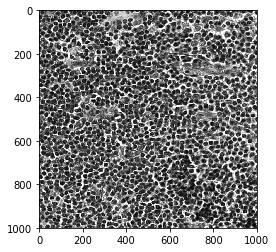

In [11]:
plt.imshow(H_channel, cmap='gray')

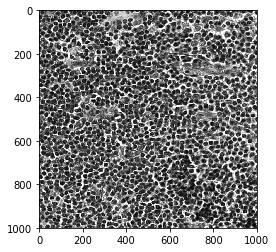

In [12]:
plt.imshow(rgb2gray(H_channel), cmap='gray')

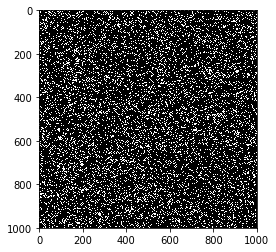

In [15]:
edges = canny(rgb2gray(H_channel), sigma=2,
              low_threshold=0.15, high_threshold=0.8)
plt.imshow(edges, cmap='gray')

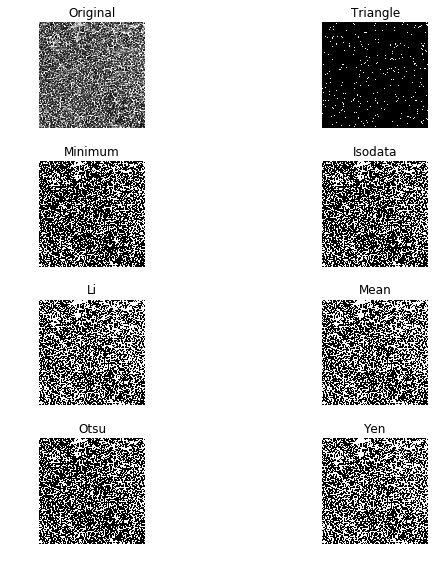

In [16]:
fig, ax = try_all_threshold(rgb2gray(H_channel), figsize=(10, 8), verbose=False)


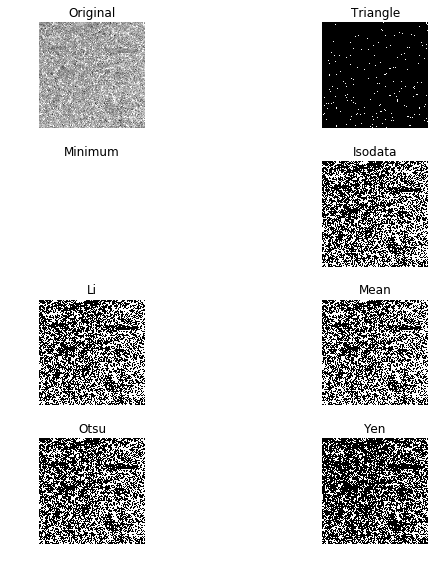

In [17]:
fig, ax = try_all_threshold(rgb2gray(E_channel), figsize=(10, 8), verbose=False)


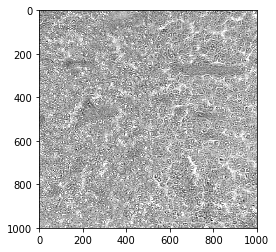

In [18]:
plt.imshow(E_channel, cmap='gray')

Text(0.5,1,'Normalized (Macenko)')

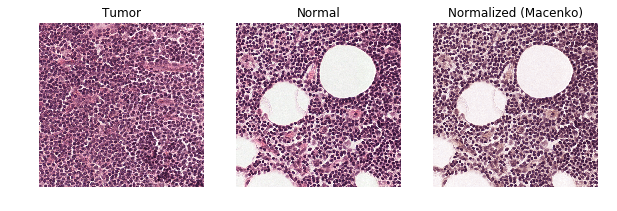

In [19]:
dif = plt.figure(figsize=(10, 10))
ax = plt.subplot(131)
ax.set_axis_off()
ax.imshow(tumor_rgb)
ax.set_title('Tumor')

ax = plt.subplot(132)
ax.set_axis_off()
ax.imshow(normal_rgb)
ax.set_title('Normal')

ax = plt.subplot(133)
ax.set_axis_off()
ax.imshow(normalized_rgb[0])
ax.set_title('Normalized (Macenko)')




# Extreme example

In [2]:
i3 = read_as_rgb('../data/images/i3.png')

In [3]:
macenko_fit = MacenkoNormalization()
macenko_fit.fit(np.asarray(i3).astype(np.uint8))
H_channel = macenko_fit.get_hematoxylin_channel(i3)


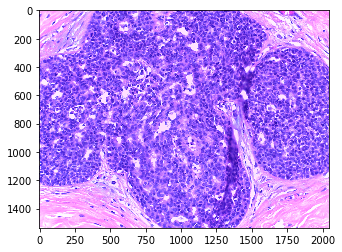

In [5]:
plt.imshow(i3)

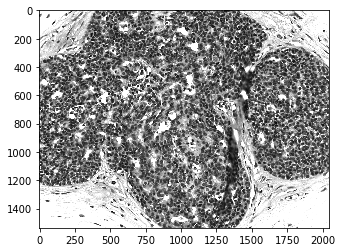

In [7]:
plt.imshow(H_channel, cmap='gray')

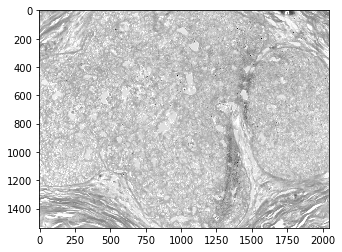

In [9]:
E_channel = macenko_fit.get_eosin_channel(i3)

plt.imshow(E_channel, cmap='gray')